In [9]:
import torch
import json
import h5py
import numpy as np
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFont
import cv2

In [10]:
image_file = json.load(open("/home/kim/mini_cond_sgg_env/Scene-Graph-Benchmark/datasets/vg_fiona/image_data-Fiona.json"))
vocab_file = json.load(open("/home/kim/mini_cond_sgg_env/Scene-Graph-Benchmark/datasets/vg_ata/VG-SGG-dicts-with-attri-ata.json"))
data_file = h5py.File("/home/kim/mini_cond_sgg_env/Scene-Graph-Benchmark/datasets/vg_ata/VG-SGG-with-attri-ata.h5", 'r')
# remove invalid image
corrupted_ims = [1592, 1722, 4616, 4617]
tmp = []
for item in image_file:
    if int(item['image_id']) not in corrupted_ims:
        tmp.append(item)
image_file = tmp

In [11]:
# load detected results
detected_origin_path = "/home/kim/checkpoints/causal-motifs-sggen-ata/inference_SGCls/VG_Ata_test/"
detected_origin_result = torch.load(detected_origin_path + 'eval_results.pytorch')
detected_info = json.load(open(detected_origin_path + 'visual_info.json'))

In [12]:
# get image info by index
def get_info_by_idx(idx, det_input, thres=0.5):
    groundtruth = det_input['groundtruths'][idx]
    prediction = det_input['predictions'][idx]
    # image path
    img_path = detected_info[idx]['img_file']
    # boxes
    boxes = groundtruth.bbox
    # object labels
    idx2label = vocab_file['idx_to_label']
    labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(groundtruth.get_field('labels').tolist())]
    pred_labels = ['{}-{}'.format(idx,idx2label[str(i)]) for idx, i in enumerate(prediction.get_field('pred_labels').tolist())]
    # groundtruth relation triplet
    idx2pred = vocab_file['idx_to_predicate']
    gt_rels = groundtruth.get_field('relation_tuple').tolist()
    gt_rels = [(labels[i[0]], idx2pred[str(i[2])], labels[i[1]]) for i in gt_rels]
    # prediction relation triplet
    pred_rel_pair = prediction.get_field('rel_pair_idxs').tolist()
    pred_rel_label = prediction.get_field('pred_rel_scores')
    pred_rel_label[:,0] = 0
    pred_rel_score, pred_rel_label = pred_rel_label.max(-1)
    #mask = pred_rel_score > thres
    #pred_rel_score = pred_rel_score[mask]
    #pred_rel_label = pred_rel_label[mask]
    pred_rels = [(pred_labels[i[0]], idx2pred[str(j)], pred_labels[i[1]]) for i, j in zip(pred_rel_pair, pred_rel_label.tolist())]
    return img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, pred_labels


In [13]:
# def draw_single_box(pic, box, color='red', draw_info=None):
#     draw = ImageDraw.Draw(pic)
#     x1,y1,x2,y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
#     draw.rectangle(((x1, y1), (x2, y2)), outline=color)
#     if draw_info:
#         draw.rectangle(((x1, y1), (x1+50, y1+10)), fill=color)
#         info = draw_info
#         draw.text((x1, y1), info)

# from PIL import ImageDraw, ImageFont

def draw_single_box(pic, box, color='red', draw_info=None, font_size=40):  # font_size를 조정
    draw = ImageDraw.Draw(pic)
    x1, y1, x2, y2 = int(box[0]), int(box[1]), int(box[2]), int(box[3])
    draw.rectangle(((x1, y1), (x2, y2)), outline=color)

    if draw_info:
        try:
            font = ImageFont.truetype("/home/kim/arial.ttf", font_size)  # 여기에서 font_size를 사용
        except IOError:
            font = ImageFont.load_default()  # 기본 폰트 사용

        text_bbox = draw.textbbox((x1, y1), draw_info, font=font)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]
        
        draw.rectangle(((x1, y1), (x1 + text_width, y1 + text_height)), fill=color)
        draw.text((x1, y1), draw_info, fill="white", font=font)


def print_list(name, input_list):
    for i, item in enumerate(input_list):
        print(name + ' ' + str(i) + ': ' + str(item))
    
def draw_image(img_path, boxes, labels, gt_rels, pred_rels, pred_rel_score, pred_rel_label, pred_labels, print_img=True):
    pic = Image.open(img_path)
    num_obj = boxes.shape[0]
    for i in range(num_obj):
        info = labels[i]
        draw_single_box(pic, boxes[i], draw_info=info)
    if print_img:
        display(pic)
        print('*' * 50)
        print_list('gt_boxes', labels)
        print('*' * 50)
        print_list('gt_rels', gt_rels)
        print('*' * 50)
        print_list('pred_labels', pred_labels)  # Print the predicted labels
        print('*' * 50)
    print_list('pred_rels', pred_rels[:20])
    print('*' * 50)
    
    return None


In [14]:
def show_selected(idx_list):
    for select_idx in idx_list:
        print(select_idx)
        draw_image(*get_info_by_idx(select_idx, detected_origin_result))
        
def show_all(start_idx, length):
    for cand_idx in range(start_idx, start_idx+length):
        print(cand_idx)
        draw_image(*get_info_by_idx(cand_idx, detected_origin_result))


2


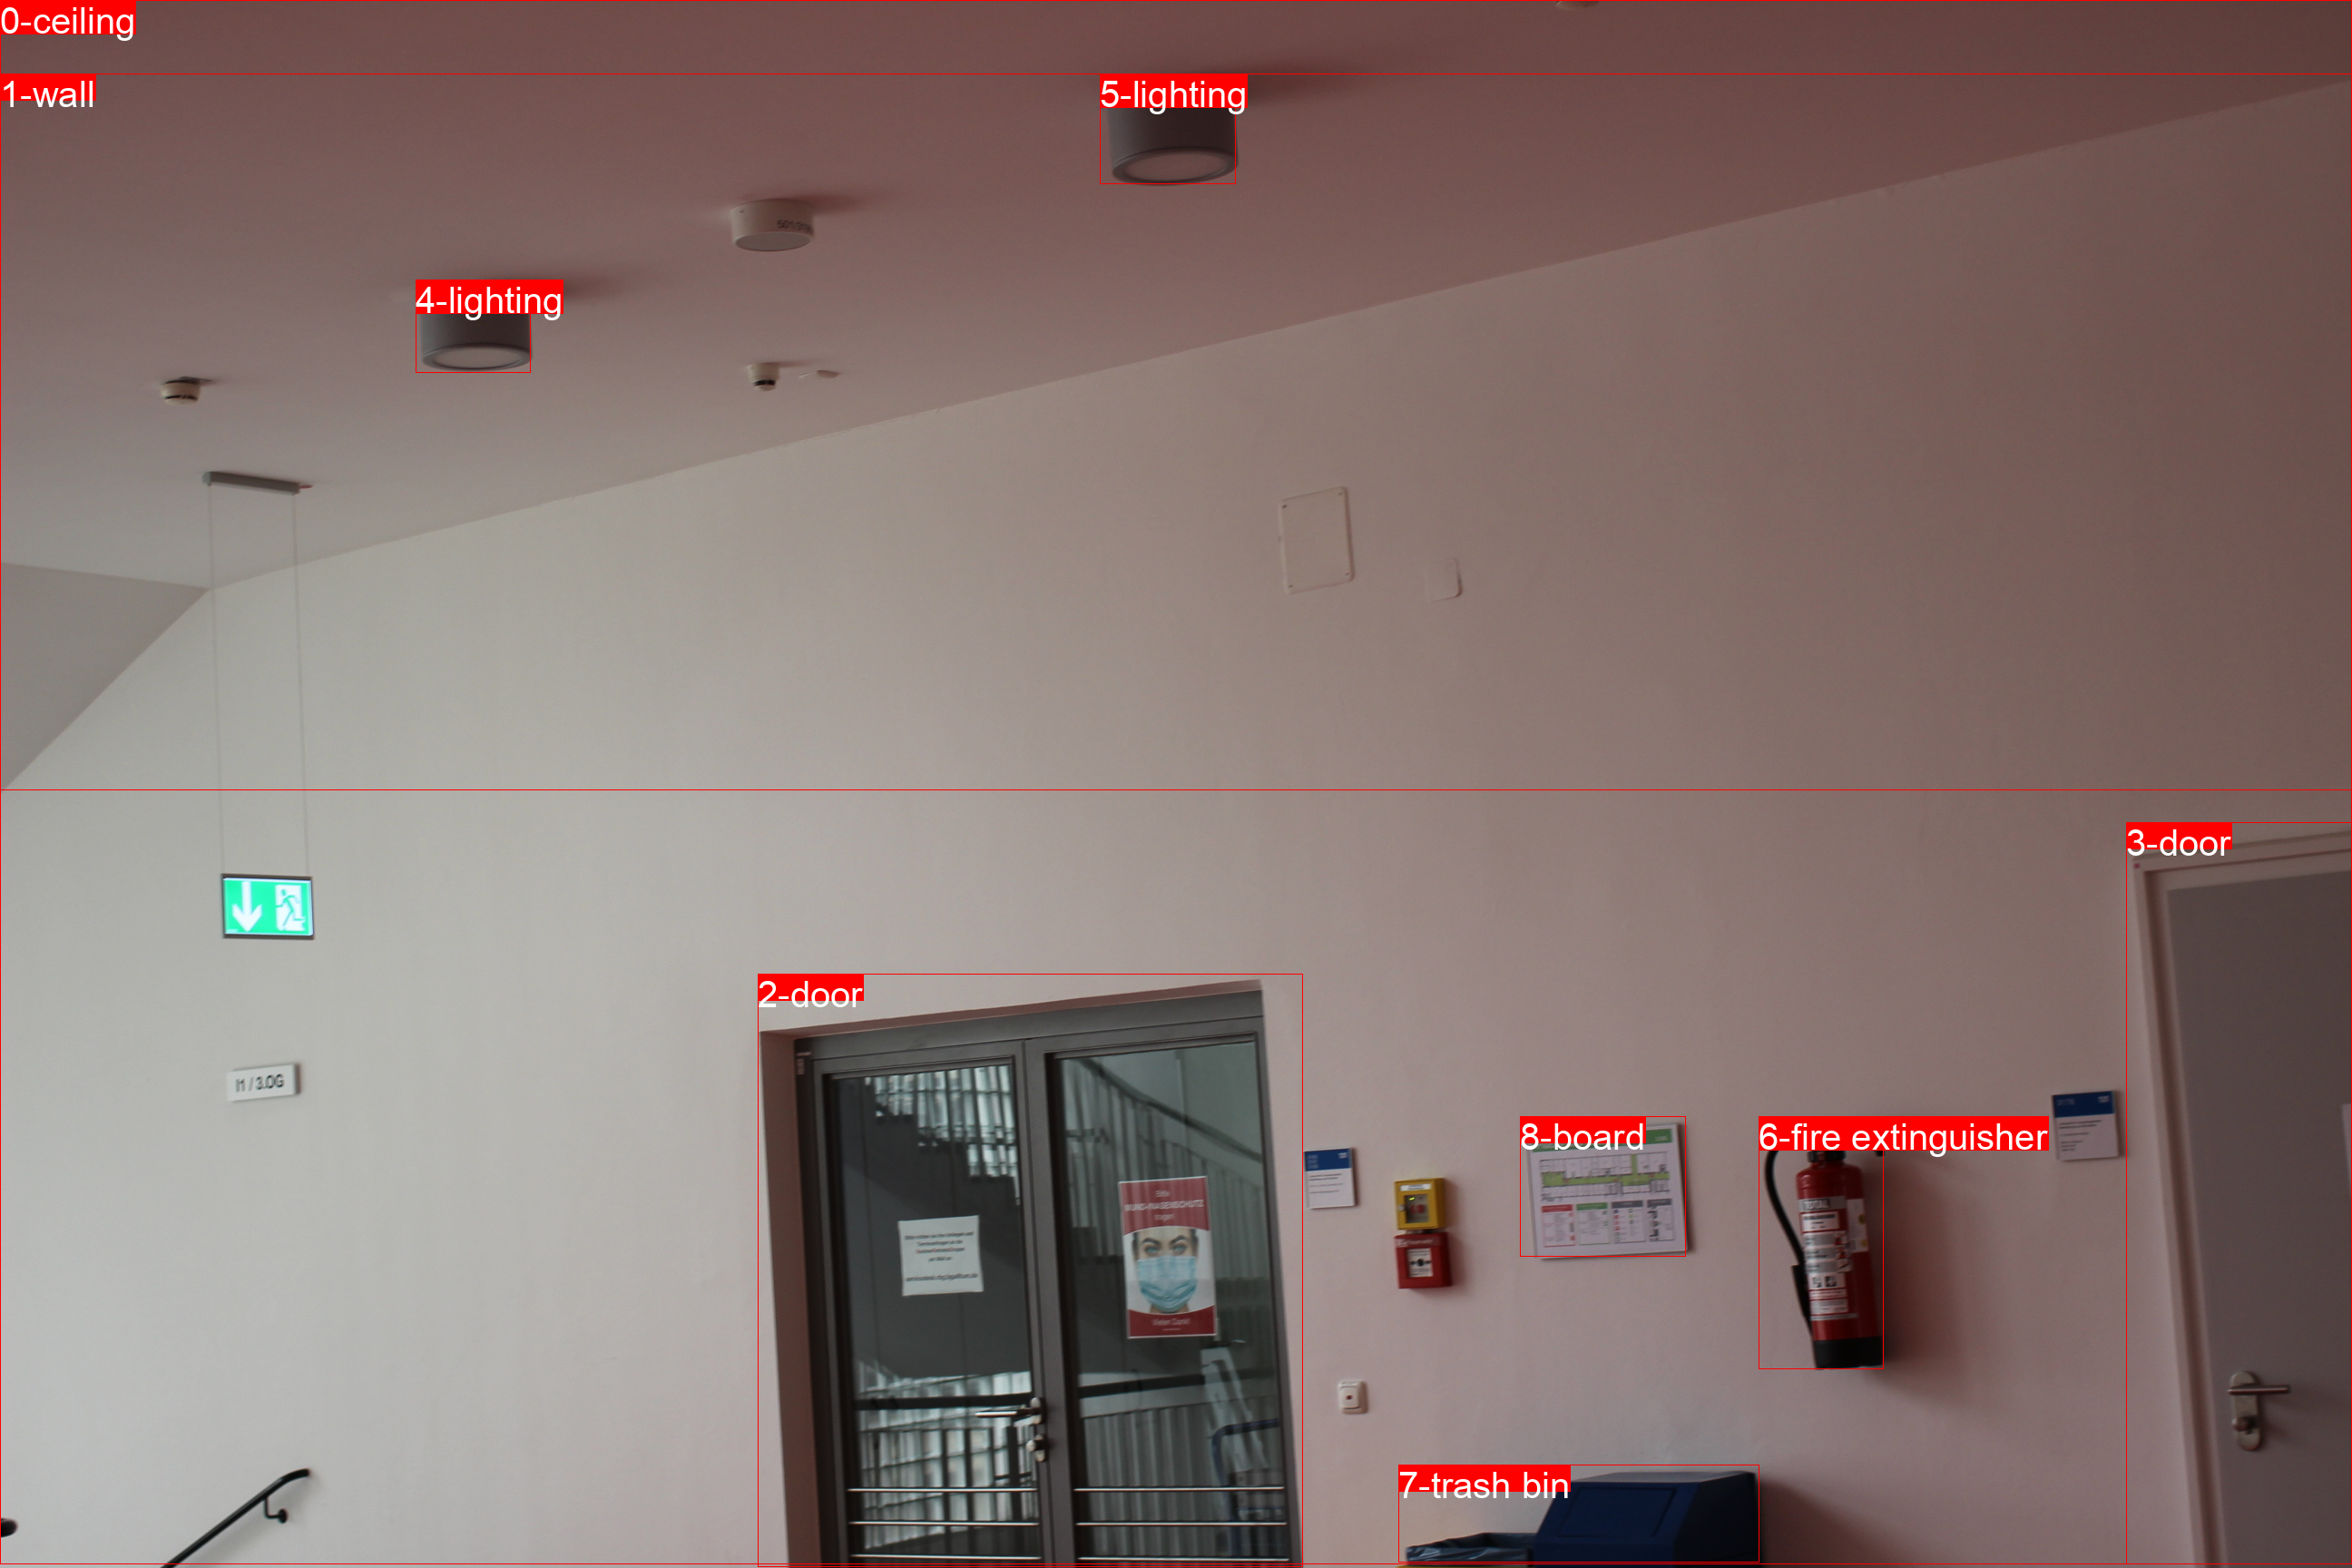

**************************************************
gt_boxes 0: 0-ceiling
gt_boxes 1: 1-wall
gt_boxes 2: 2-door
gt_boxes 3: 3-door
gt_boxes 4: 4-lighting
gt_boxes 5: 5-lighting
gt_boxes 6: 6-fire extinguisher
gt_boxes 7: 7-trash bin
gt_boxes 8: 8-board
**************************************************
gt_rels 0: ('2-door', 'has opening in', '1-wall')
gt_rels 1: ('3-door', 'has opening in', '1-wall')
gt_rels 2: ('4-lighting', 'mounted on', '0-ceiling')
gt_rels 3: ('5-lighting', 'mounted on', '0-ceiling')
gt_rels 4: ('6-fire extinguisher', 'attached to', '1-wall')
gt_rels 5: ('6-fire extinguisher', 'attached to', '1-wall')
gt_rels 6: ('8-board', 'fixed on', '1-wall')
gt_rels 7: ('6-fire extinguisher', 'next to', '8-board')
gt_rels 8: ('1-wall', 'joined with', '0-ceiling')
**************************************************
pred_labels 0: 0-wall
pred_labels 1: 1-wall
pred_labels 2: 2-door
pred_labels 3: 3-door
pred_labels 4: 4-lighting
pred_labels 5: 5-speaker
pred_labels 6: 6-door sign
pr

In [15]:
# show_all(start_idx=0, length=5)
show_selected([2])